# Simple fwd / inv of a polarized block

In this notebook, I set up a simple example where we use the dipole model to run a simulation and an inversion over a polarized block. This is mostly to test if the inversion is working and to compare if we impose positivity or not. 

In [1]:
import discretize
import numpy as np
from matplotlib import pyplot as plt
import SimPEG as simpeg
import geoana
import scipy.sparse as sp

import polarizability_model as pm

In [2]:
core_domain = 3 # meters
dx = 0.1
nc = int(core_domain / dx) + 1
npad = 2
pf = 1.3
hx = [(dx, npad, -pf), (dx, nc), (dx, npad, pf)]
hy = [(dx, npad, -pf), (dx, nc), (dx, npad, pf)]
mesh = discretize.TensorMesh([hx, hy], origin="CC")

In [3]:
locations = np.hstack([mesh.gridCC, np.zeros((mesh.nC, 1))])

### Start with a simple example
- uniform inducing field in x, y, z
- grid of receivers in the core domain

In [4]:
rx_x = np.linspace(-core_domain/2, core_domain/2, 20)
rx_y = rx_x
rx_z = np.r_[0.25]

rx_locs = discretize.utils.ndgrid([rx_x, rx_y, rx_z])

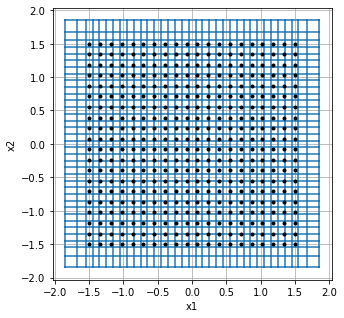

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

mesh.plot_grid(ax=ax)
ax.plot(rx_locs[:, 0], rx_locs[:, 1], 'k.')

In [6]:
receiver = pm.MagneticFluxDensityReceiver(rx_locs, components=["x", "y", "z"])
nrx = rx_locs.shape[0]

In [7]:
receiver.components

['x', 'y', 'z']

In [8]:
pm.survey.component_dictionary

{'x': 0, 'y': 1, 'z': 2}

In [9]:
receiver_components = np.zeros((0, len(receiver.components)))

for comp in receiver.components:
    if comp in receiver.components:
        e = np.zeros(3)
        e[pm.survey.component_dictionary[comp]] = 1
        receiver_components = np.vstack(
            [receiver_components, e])

In [10]:
receiver_components

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [11]:
src_list = [
    pm.MagneticUniformSource([receiver], orientation) for orientation in ["x", "y", "z"]
]               

In [12]:
survey = pm.Survey(src_list)

In [13]:
sim = pm.SimulationPolarizabilityModel(locations, survey)

In [14]:
mtrue = np.zeros_like(locations)

x_target = np.r_[-0.25, 0.25]
y_target = np.r_[-0.25, 0.25]
m_target = np.r_[0.1, 0.1, 2]

bounding_box = (
    (locations[:, 0] > x_target.min()) &
    (locations[:, 0] < x_target.max()) &
    (locations[:, 1] > y_target.min()) &
    (locations[:, 1] < y_target.max()) 
)
for i, m in enumerate(m_target): 
    mtrue[bounding_box, i] = m

mtrue = mtrue.flatten() #discretize.utils.mkvc(mtrue)

In [15]:
def plot_model(model, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 3, figsize=(11, 3))
    
    for i, label in enumerate(["x", "y", "z"]): 
        plt.colorbar(mesh.plot_image(model[i::3], ax=ax[i])[0], ax=ax[i])
        ax[i].set_title(f"$m_{label}$")
        ax[i].set_aspect(1)
    plt.tight_layout()

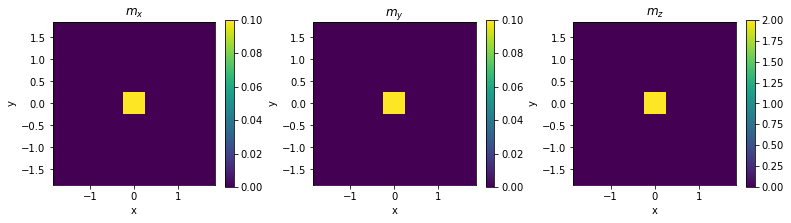

In [16]:
plot_model(mtrue)

In [17]:
dtrue = sim.dpred(mtrue.flatten())
# data_true = simpeg.Data(survey, dtrue)

In [18]:
# plot the data

def plot_data(dplot, ax=None): 
    if ax is None: 
        fig, ax = plt.subplots(3,3, figsize=(10, 8))

    contour_opts = {
        "cmap": "Spectral_r"
    }
    n_interpolate = 40

    for i, src in enumerate(src_list):
        for j, comp in enumerate(src.receiver_list[0].components): 
            dij = dplot[i*3*nrx:(i+1)*3*nrx][j::3]
            if np.any(dij): 
                contour_opts["vmin"] = -1*np.max(np.abs(dij))
                contour_opts["vmax"] = np.max(np.abs(dij))
                plt.colorbar(
                    simpeg.utils.plot2Ddata(
                        rx_locs[:,:2], dij, ax=ax[i, j], 
                        contourOpts=contour_opts, nx=n_interpolate, ny=n_interpolate
                    )[0], 
                    ax=ax[i, j]
                )
            ax[i, j].set_title(f"src: {src.orientation}, rx: {comp}")
            ax[i, j].set_aspect(1)
    plt.tight_layout()
    return ax

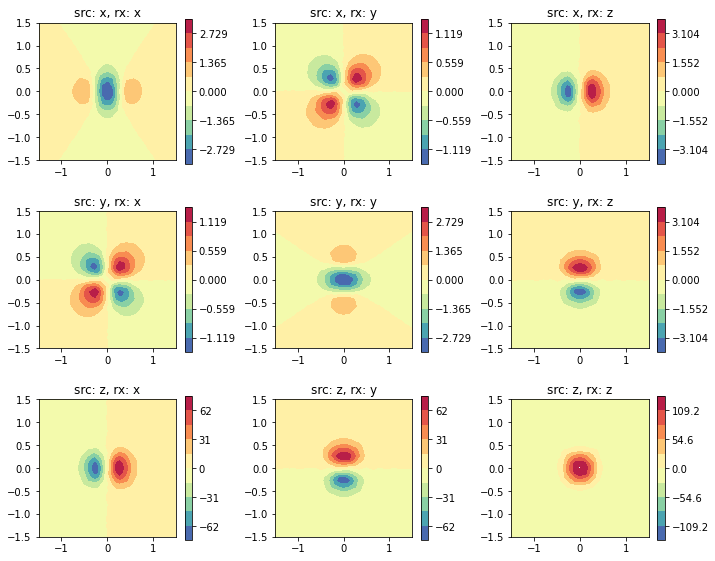

In [19]:
plot_data(dtrue);

# try a simple inversion

In [20]:
import pydiso
from pymatsolver import Pardiso as Solver

In [21]:
noise_floor = 0.01 * np.max(np.abs(dtrue))

G = np.vstack(sim.G)
Wd = (1./noise_floor) * np.eye(survey.nD)
WdG = Wd @ G
WdG2 = WdG.T @ WdG 
rhs = WdG.T @ Wd @ dtrue

In [22]:
beta = 1
A =  WdG2 + beta * np.eye(locations.shape[0]*3)

In [23]:
%%time
Ainv = Solver(sp.csr_matrix(A))
mrec = Ainv * rhs

CPU times: user 4.76 s, sys: 838 ms, total: 5.6 s
Wall time: 4.48 s


In [24]:
r = 1./noise_floor*(G@mrec-dtrue)
print(np.inner(r,r), survey.nD)

95960.6337419298 3600


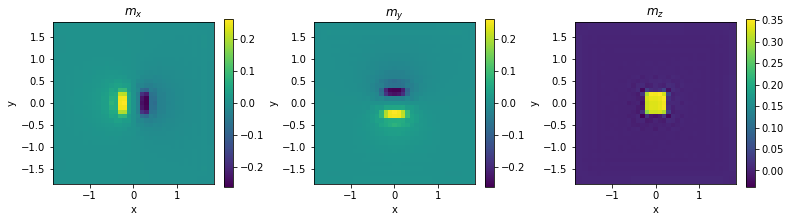

In [25]:
plot_model(mrec)

# inversion that enforces positivity -- SimPEG

In [26]:
from SimPEG import (
    data_misfit, regularization, optimization, inverse_problem, inversion, directives, Data, maps
)



In [27]:
noise_floor = 0.01 * np.max(np.abs(dtrue))
print(noise_floor)

1.364744329279153


In [28]:
dmis = data_misfit.L2DataMisfit(
    data=Data(survey, dobs=dtrue, noise_floor=noise_floor), simulation=sim
)

nmodel = mesh.nC*3
map_x = maps.Projection(nP=nmodel, index=slice(0,nmodel,3))
map_y = maps.Projection(nP=nmodel, index=slice(1,nmodel,3))
map_z = maps.Projection(nP=nmodel, index=slice(2,nmodel,3))
reg = (
    regularization.SimpleSmall(mesh, mapping=map_x, mref=np.zeros(len(locations)*3)) + 
    regularization.SimpleSmall(mesh, mapping=map_y, mref=np.zeros(len(locations)*3)) + 
    regularization.SimpleSmall(mesh, mapping=map_z, mref=np.zeros(len(locations)*3))  
)

In [29]:
opt = optimization.ProjectedGNCG(maxIterCG=40, lower=0, maxIter=20) 
invprob = inverse_problem.BaseInvProblem(dmis, reg, opt) 

In [30]:
directive_list = [
    directives.BetaEstimate_ByEig(beta0_ratio=2), 
    directives.BetaSchedule(coolingFactor=2.0, coolingRate=1),
    directives.TargetMisfit()
]

In [31]:
inv = inversion.BaseInversion(invprob, directive_list)

In [32]:
mrec_pos = inv.run(np.zeros(mesh.nC * 3)+1e-20)


        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0


/Users/lindseyjh/opt/miniconda3/envs/uxo/lib/python3.8/site-packages/pymatsolver/direct.py:23: PardisoTypeConversionWarning: Converting csc_matrix matrix to CSR format, will slow down.
  self.solver = MKLPardisoSolver(


   0  3.88e+03  7.20e+04  1.84e-37  7.20e+04    1.59e+04      0              


/Users/lindseyjh/opt/miniconda3/envs/uxo/lib/python3.8/site-packages/pymatsolver/direct.py:73: PardisoTypeConversionWarning: Converting csc_matrix matrix to CSR format, will slow down.
  self.solver.refactor(self.A)


   1  1.94e+03  3.49e+04  3.80e+00  4.23e+04    5.63e+03      0              
   2  9.69e+02  2.03e+04  9.14e+00  2.91e+04    4.14e+03      0   Skip BFGS  
   3  4.85e+02  9.65e+03  1.68e+01  1.78e+04    2.81e+03      0   Skip BFGS  
   4  2.42e+02  3.80e+03  2.52e+01  9.90e+03    1.71e+03      0   Skip BFGS  
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 7.1971e+03
0 : |xc-x_last| = 9.4559e-01 <= tolX*(1+|x0|) = 1.0000e-01
0 : |proj(x-g)-x|    = 1.7113e+03 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 1.7113e+03 <= 1e3*eps       = 1.0000e-02
0 : maxIter   =      20    <= iter          =      5
------------------------- DONE! -------------------------


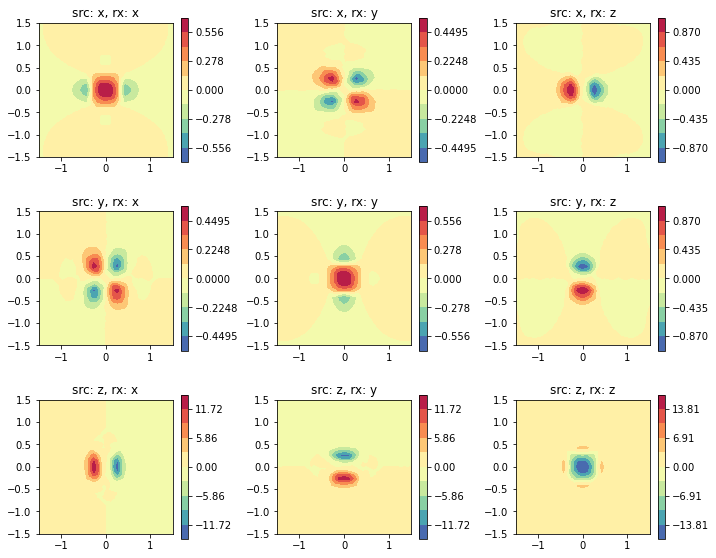

In [33]:
plot_data(invprob.dpred - dtrue);

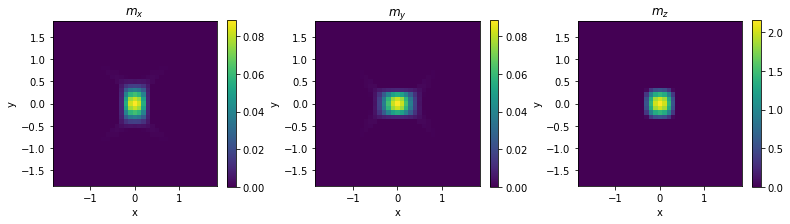

In [34]:
plot_model(mrec_pos)